In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
df_jan = pd.read_parquet('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet')
df_feb = pd.read_parquet('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet')

# Question 1

In [5]:
df_jan.shape

(1154112, 7)

# Question 2

In [8]:
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037


In [7]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 61.6+ MB


In [23]:
df_jan['duration'] = (df_jan.dropOff_datetime - df_jan.pickup_datetime)

In [24]:
df_jan.duration.describe()

count                      1154112
mean     0 days 00:19:10.033445627
std      0 days 06:38:41.529882844
min                0 days 00:00:01
25%                0 days 00:07:46
50%                0 days 00:13:24
75%                0 days 00:22:17
max              294 days 00:11:03
Name: duration, dtype: object

In [25]:
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() /60)

In [26]:
df_jan.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

## Data preparation
Check the distribution of the duration variable. There are some outliners.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

C:\ProgramData\Anaconda3\envs\mlops\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

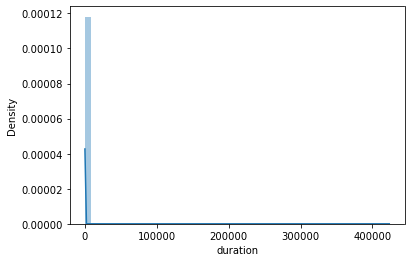

In [27]:
sns.distplot(df_jan.duration)

In [30]:
df_jan = df_jan[(df_jan.duration >=1) & (df_jan.duration <= 60)]

In [31]:
df_jan.shape

(1109826, 8)

In [32]:
print('dropped records: ', 1154112-1109826)

dropped records:  44286


## Question 3

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1"

What's the factions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

In [33]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109826 entries, 0 to 1154111
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1109826 non-null  object        
 1   pickup_datetime         1109826 non-null  datetime64[ns]
 2   dropOff_datetime        1109826 non-null  datetime64[ns]
 3   PUlocationID            182818 non-null   float64       
 4   DOlocationID            961919 non-null   float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1109053 non-null  object        
 7   duration                1109826 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 76.2+ MB


In [39]:
df_jan.PUlocationID.value_counts(dropna = False)

-1.0      927008
 221.0      8330
 206.0      6797
 129.0      5379
 115.0      4082
           ...  
 111.0         5
 27.0          4
 34.0          3
 2.0           2
 110.0         1
Name: PUlocationID, Length: 262, dtype: int64

In [36]:
(df_jan.PUlocationID.isna().sum()/df_jan.shape[0])*100

83.52732770722618

In [38]:
df_jan.PUlocationID.fillna(-1, inplace = True)

In [40]:
df_jan.DOlocationID.fillna(-1, inplace = True)

## Question 4

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix? (The number of columns)

In [51]:
df_jan.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                          float64
Affiliated_base_number            object
duration                         float64
dtype: object

In [53]:
df_jan['PUlocationID'] = df_jan['PUlocationID'].astype(str)
df_jan['DOlocationID'] = df_jan['DOlocationID'].astype(str)

In [54]:
df_jan_dict = df_jan[['PUlocationID', 'DOlocationID']].to_dict(orient = 'records')

In [55]:
dv = DictVectorizer()

In [56]:
X_train = dv.fit_transform(df_jan_dict)

In [57]:
X_train.shape

(1109826, 525)

In [58]:
y = df_jan.duration.values

## Question 5

In [60]:
lr = LinearRegression()

In [62]:
lr.fit(X_train, y)

LinearRegression()

In [64]:
y_pred_train = lr.predict(X_train)

In [66]:
mean_squared_error(y, y_pred_train, squared = False)

10.528519107212375